In [253]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling

import scipy.io
from scipy.interpolate import griddata
import sys
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

#Set default dtype to float32
torch.set_default_dtype(torch.float)

np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


## Data Preparation

In [254]:
def Generate_Excat(a1,a2,x,y):
    Exact =np.sin(a1*x) * np.sin(a2*y) #网格化坐标上的真解
    return Exact

def Generate_Gra(a1,a2,x,y):
    grax =a1* np.cos(a1*x) * np.sin(a2*y)
    graxx=-a1**2* np.sin(a1*x) * np.sin(a2*y)
    gray =a2*np.sin(a1*x) * np.cos(a2*y)
    grayy=-a2**2*np.sin(a1*x) * np.sin(a2*y)
    return grax,gray,graxx,grayy

In [255]:
#真解系数
a1=2
a2=2
#真实波数
k_true =np.sqrt(a1**2+a2**2)#波数（单频）
#数据域划分
lin_num = 100
y = np.linspace(-1,1,lin_num)[:,None] #Y采样点
x = np.linspace(-1,1,lin_num)[:,None] #X采样点
X, Y = np.meshgrid(x,y)
Exact =Generate_Excat(a1,a2,X,Y) #网格化坐标上的真解
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_star = Exact.flatten()[:,None]  
#边界
lb = X_star.min(0)
ub = X_star.max(0) 

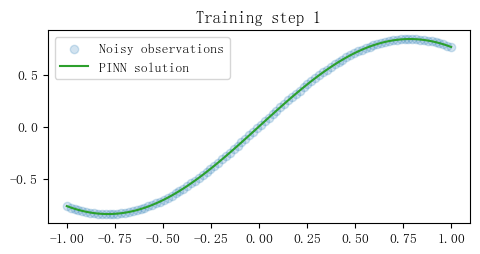

In [256]:
# 测试数据集 x=0.2的直线上
y_test = np.linspace(-1,1,lin_num)[:,None] #Y采样点
x_test = np.full(lin_num,0.5)[:,None]
u_test =np.sin(a1*x_test) * np.sin(a2*y_test) #网格化坐标上的真解
plt.figure(figsize=(12, 2.5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, u_test, label="Noisy observations", alpha=0.2, color="tab:blue")
plt.plot(y_test[:, 0], u_test[:, 0], label="PINN solution", color="tab:green")
plt.title(f"Training step {1}")
plt.legend()

## Physics-informed Neural Networks

In [257]:
# the deep neural network
class Solu_NN(torch.nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with Recommended gain value?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,X):
         
        a = X.float()


        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        out = self.linears[-1](a)


        return out

In [258]:
# the physics-guided neural network
class PINN(torch.nn.Module):
    def __init__(self, X, u, layers, lb, ub, pdelam , datalam,iternum):
        super().__init__() #call __init__ from parent class 
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings

        self.k = torch.tensor([1.], requires_grad=True).to(device)  # 初始化一个波数（自己选择）  
        self.k = torch.nn.Parameter(self.k)
        # deep neural networks
        self.u_nn = Solu_NN(layers).to(device)
        self.u_nn.register_parameter('k', self.k)
        # loss lambda
        self.pdelam=torch.tensor(pdelam).float().to(device)
        self.datalam=torch.tensor(datalam).float().to(device)
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.u_nn.parameters(), 
            lr=1, 
            max_iter=iternum, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-9, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        #训练过程记录
        self.iter = 0
        self.klist = []
        self.pdelosslist=[]
        self.datalosslist = []
        
    def net_u(self, x, y):  
        u = self.u_nn(torch.cat([x, y], dim=1))
        return u
    
    def net_f(self, x, y):
        """ The pytorch autograd version of calculating residual """
        k =self.k
        u = self.net_u(x, y)
        
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        f = u_yy + u_xx +k*k*u

        #loss_g_x = torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), retain_graph=True, create_graph=True)[0]
        #loss_g_t = torch.autograd.grad(f, t, grad_outputs=torch.ones_like(f), retain_graph=True, create_graph=True)[0]
        return f#,loss_g_x,loss_g_t
    
    def get_gra(self):
        """get grad"""
        x = self.x
        y = self.y
        u = self.net_u(x, y)
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        return u,u_x,u_y,u_xx,u_yy
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.y)
        f_pred = self.net_f(self.x, self.y)
        loss_data = torch.mean((self.u - u_pred)**2)
        loss_pde = torch.mean(f_pred**2 )
        #loss_gradient =torch.mean(loss_g_x**2)+torch.mean(loss_g_t**2)
        loss = self.datalam*loss_data+self.pdelam*loss_pde#+loss_gradient
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        # if self.iter % 100 == 0:
        #     print(
        #         'Loss: %e, loss_data: %e, loss_pde: %e, k: %.5f' % 
        #         (
        #             loss.item(), 
        #             loss_data.item(), 
        #             loss_pde.item(), 
        #             #loss_gradient.item(),
        #             self.k.item()
        #         )
        #     )
        self.klist.append(self.k.item())
        self.pdelosslist.append(loss_pde.item())
        self.datalosslist.append(loss_data.item())

        # 训练进度的可视化
        if self.iter % 500 == 0:

            plt.figure(figsize=(15, 2.5))

            # 绘制观测数据和PINN解
            plt.subplot(1, 3, 1)
            plt.scatter(y_test[:, 0], u_test[:, 0], label="Noisy observations", alpha=0.6, color="tab:blue")
            # pinn预测结果
            u_pinntest = self.net_u(torch.from_numpy(x_test).to(device),torch.from_numpy(y_test).to(device))
            plt.plot(y_test[:, 0], u_pinntest[:, 0].detach().cpu().numpy(), label="PINN solution", color="tab:green")
            plt.title(f"Training step {self.iter}")
            plt.legend()
            # 绘制损失曲线
            plt.subplot(1, 3, 2)
            plt.title("$Loss$")
            plt.plot(np.log10(self.pdelosslist), label="pde loss")
            plt.plot(np.log10(self.datalosslist), label="data loss")
            #plt.plot(np.log(self.pdelosslist+self.datalosslist), label="total loss")
            plt.xlabel("Training step")
            plt.legend()
            # 绘制 mu 的估计值
            plt.subplot(1, 3, 3)
            plt.title("$k$")
            plt.plot(self.klist, label="PINN estimate", color="tab:green")
            plt.hlines(k_true, 0, len(self.klist), label="True value", color="tab:grey")
            plt.xlabel("Training step")
            plt.legend()

            plt.show()

        return loss
    
    def train(self, nIter):
        self.u_nn.train()
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u_nn.eval()
        u = self.net_u(x, y)
        u = u.detach().cpu().numpy()
        return u
    

## Training on Non-noisy Data

In [259]:
%%time
#全连接网络层数
layers = [2, 20, 50, 50,50, 20, 20,20,1]
#随机PDE采样
N_u = 5000
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]
#新建网络
model = PINN(X_u_train, u_train, layers, lb, ub,1,1,10000)
#打印网络初始误差
loss_data_init = torch.mean((model.u - model.net_u(model.x,model.y)) ** 2)
loss_pde_init = torch.mean(model.net_f(model.x,model.y)[0] ** 2)
print('loss_data_init: %e'%loss_data_init.item())
print('loss_pde_init: %e'%loss_pde_init.item())

loss_data_init: 4.712653e-01
loss_pde_init: 2.496091e-02
CPU times: total: 0 ns
Wall time: 42.7 ms


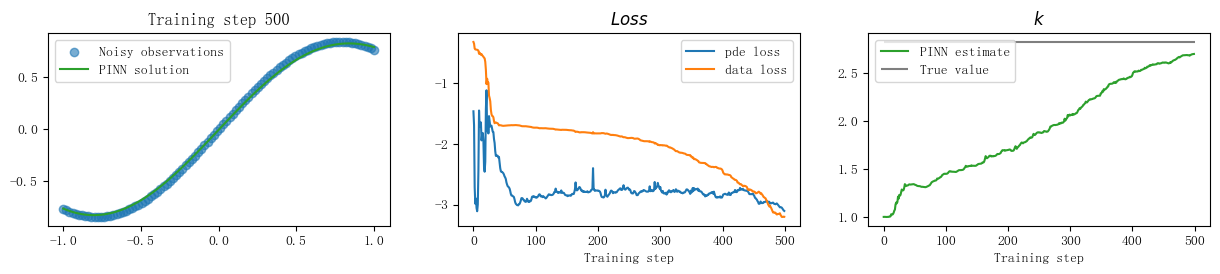

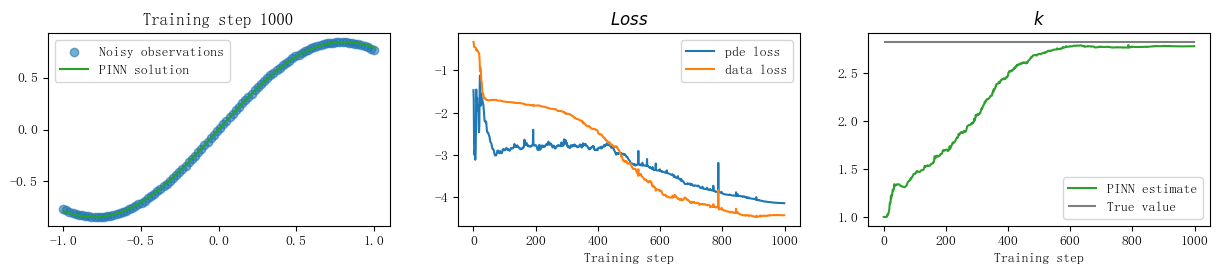

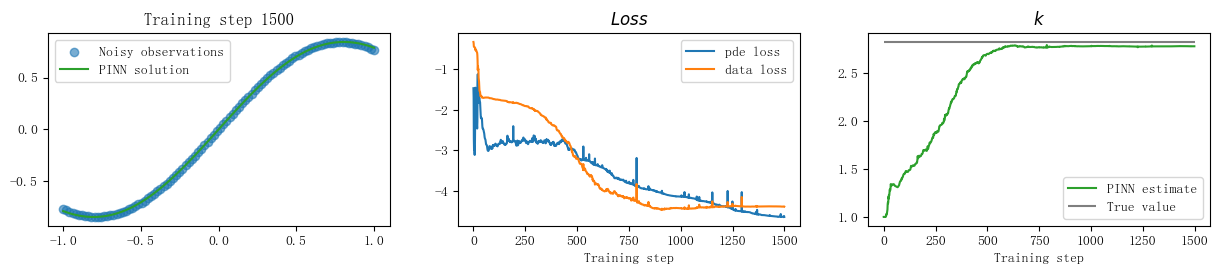

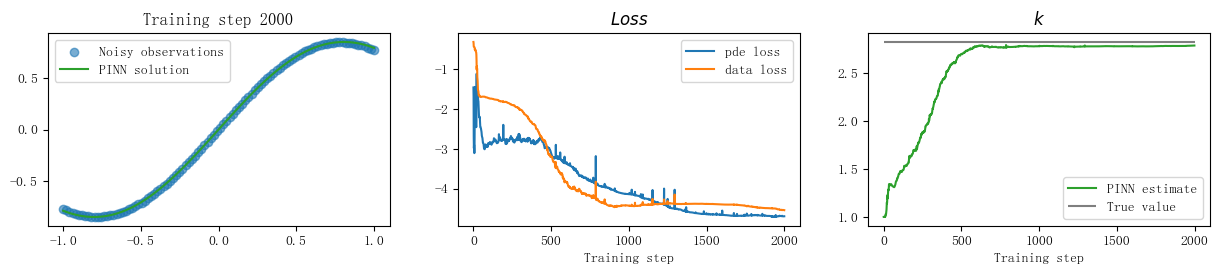

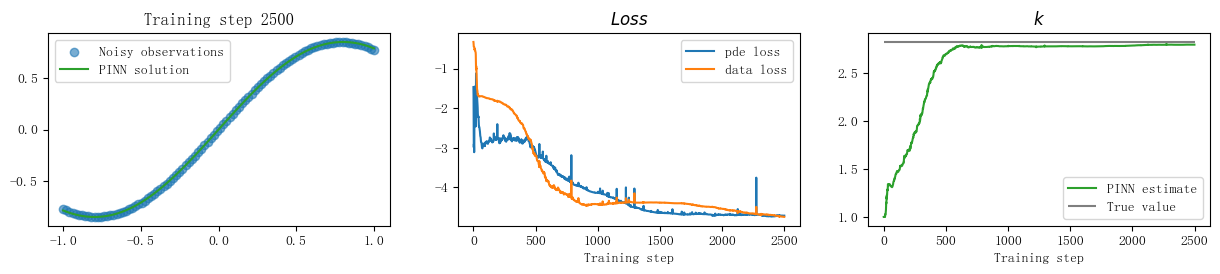

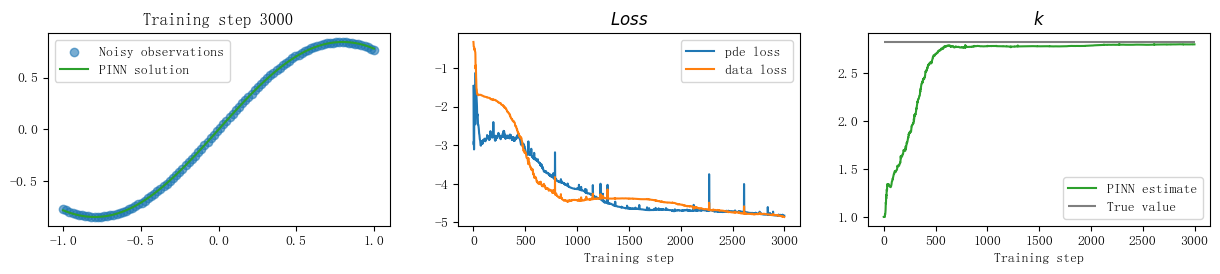

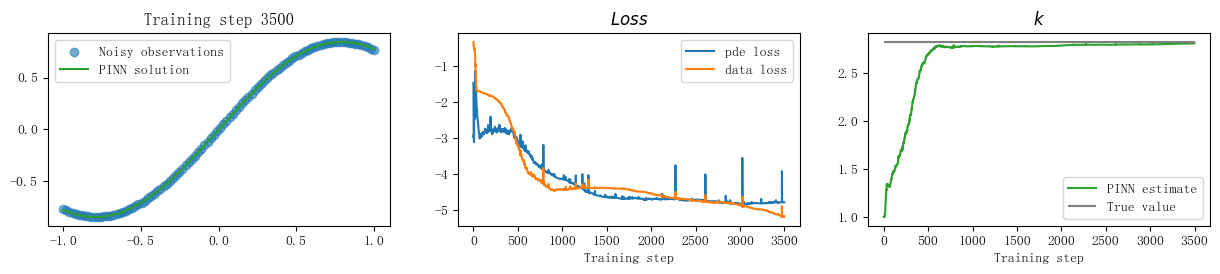

In [260]:
model.train(200)
torch.save(model.state_dict(), "./test_modelnn_save.pth")

In [261]:
model.k

Parameter containing:
tensor([2.8158], device='cuda:0', requires_grad=True)

In [262]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
# 绘制梯度曲面
def draw_gra(X,Y):
    # 获取实际梯度
    grx ,gry,grxx,gryy = Generate_Gra(a1,a2,X,Y)
    # 获取网络梯度
    net = PINN(X_star, u_star, layers, lb, ub,5,1,10000)
    net.load_state_dict(torch.load("./test_modelnn_save.pth"))
    u, grxt ,gryt,grxxt,gryyt =net.get_gra()
    grxt = grxt.reshape(lin_num,lin_num).detach().cpu().numpy()
    gryt = gryt.reshape(lin_num,lin_num).detach().cpu().numpy()
    grxxt = grxxt.reshape(lin_num,lin_num).detach().cpu().numpy()
    gryyt = gryyt.reshape(lin_num,lin_num).detach().cpu().numpy()
    kku = (net.k*net.k*u.reshape(lin_num,lin_num)).detach().cpu().numpy()

    plt.rcParams['font.sans-serif']=['FangSong'] # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号

    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(321, projection='3d')
    ax1.plot_surface(X,Y,abs(grx-grxt),cmap='rainbow') 
    plt.title('grax Error')

    ax1 = fig.add_subplot(322, projection='3d')
    ax1.plot_surface(X,Y,abs(gry-gryt),cmap='rainbow') 
    plt.title('gray Error')

    ax1 = fig.add_subplot(323, projection='3d')
    ax1.plot_surface(X,Y,abs(grxx-grxxt),cmap='rainbow') 
    plt.title('graxx Error')

    ax1 = fig.add_subplot(324, projection='3d')
    ax1.plot_surface(X,Y,abs(gryy-gryyt),cmap='rainbow') 
    plt.title('grayy Error')

    ax1 = fig.add_subplot(325,projection='3d')
    ax1.plot_surface(X,Y,kku+gryyt+grxxt,cmap='rainbow') 
    plt.title('pde_ERR')

    # ax1.view_init(elev=0,azim=135)
    # 改变cmap参数可以控制三维曲面的颜色组合, 一般我们见到的三维曲面就是 rainbow 的
    plt.savefig('./fra.png')
    plt.show()

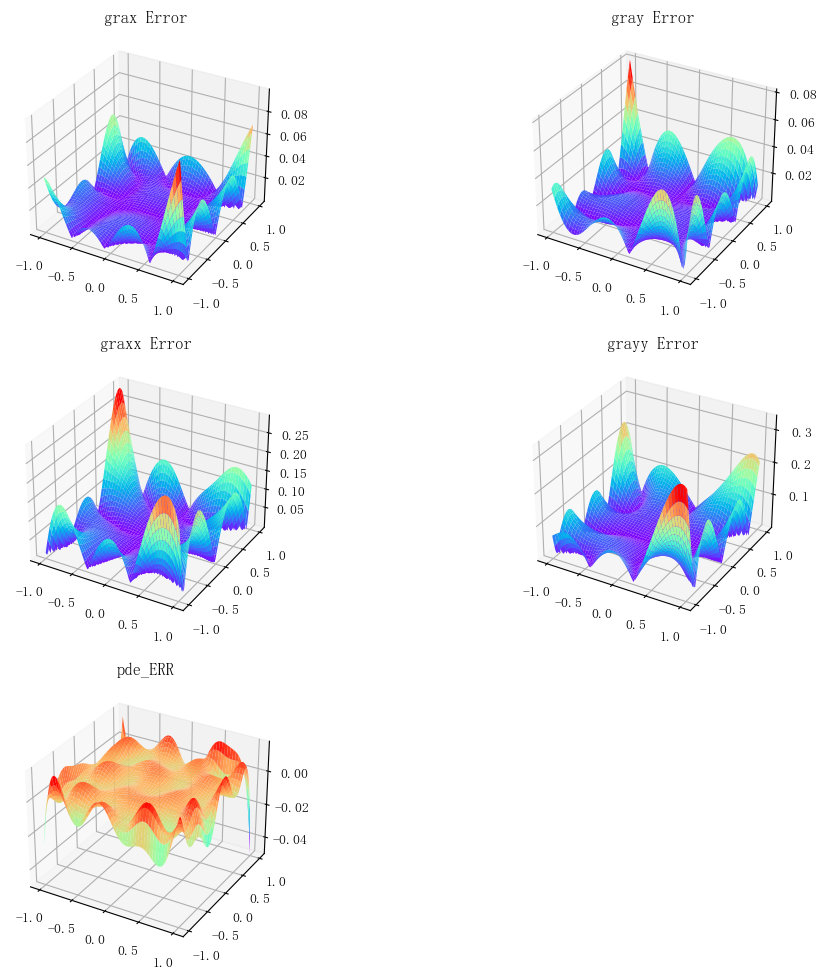

In [263]:
draw_gra(X,Y)

In [264]:
#输入全局数据进行预测
u_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')

## Plots

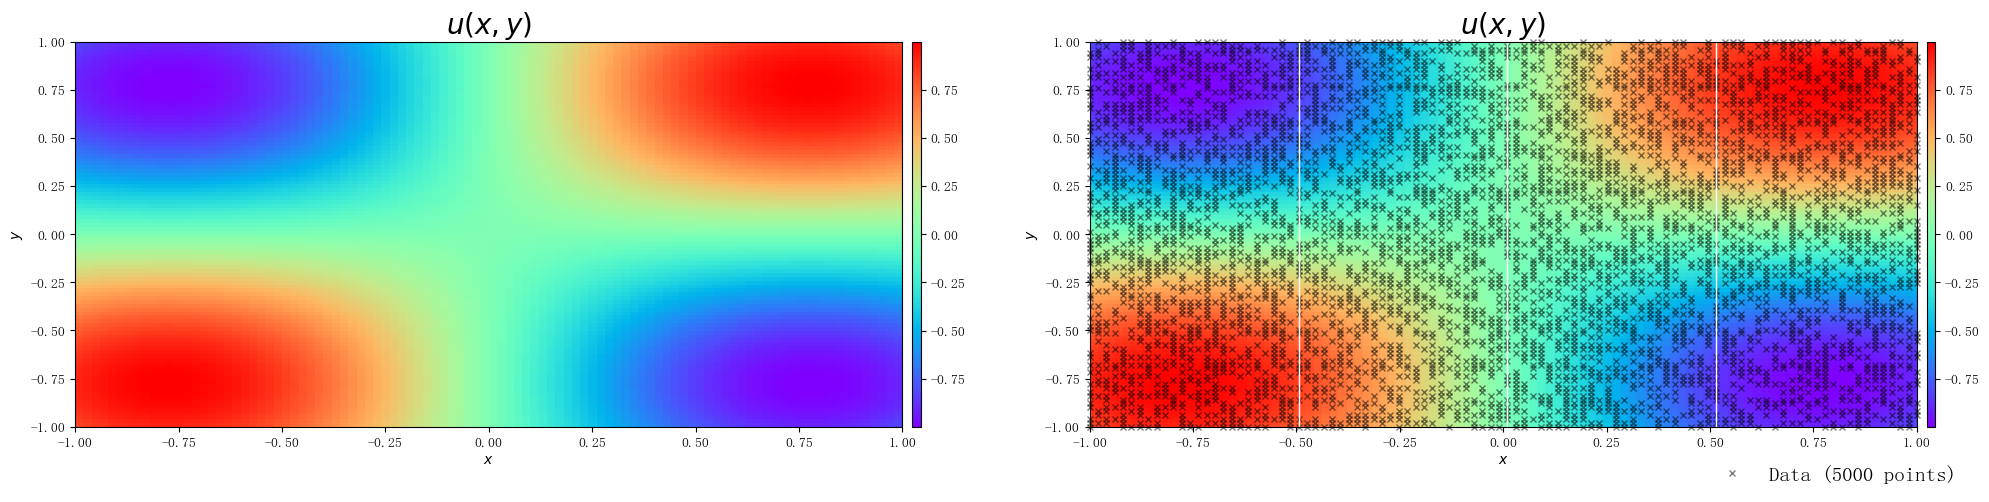

In [265]:
#绘制全局数据预测精确结果
fig = plt.figure(figsize=(24, 5))
ax = fig.add_subplot(121)
h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow', 
              extent=[y.min(), y.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10) 
ax.set_xlabel('$x$', size=10)
ax.set_ylabel('$y$', size=10)
ax.set_title('$u(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=10)
""" The aesthetic setting has changed. """
####### Row 0: u(x,y) ##################    
#绘制全局数据预测结果云图
ax = fig.add_subplot(122)
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[y.min(), y.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10) 
#绘制训练采样点
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$x$', size=10)
ax.set_ylabel('$y$', size=10)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=10)

plt.show()

C:\Users\dsj\AppData\Local\Temp\ipykernel_24120\916702570.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


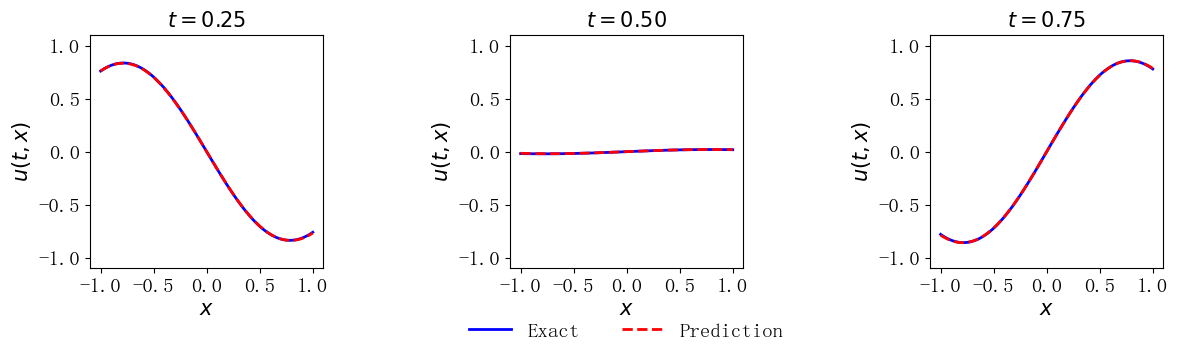

In [266]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()